In [37]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets, models
import torch
import numpy as np
from torch import nn

In [38]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path
    assert ('vgg16' in model_name or 'resnet50' in model_name), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if 'vgg16' in model_name:
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif 'resnet50' in model_name:
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print('%s total parameters.' % total_params)
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print('%s total gradient parameters.' % total_trainable_params)

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [39]:
checkpoint_path = '/scratch/hle/data/caltech101_models/vgg16-transfer-4.pth'
multi_gpu = False
train_on_gpu = True
model, optimizer = load_checkpoint(path=checkpoint_path)

135335333 total parameters.
1074789 total gradient parameters.


torch.Size([3, 224, 224])


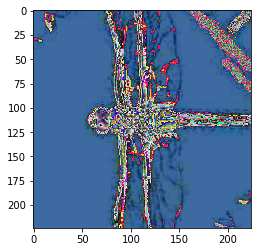

In [41]:

# read the image, resize to 224 and convert to PyTorch Tensor
test_img = Image.open("/scratch/hle/caltech_101/test/dragonfly/image_0002.jpg")
test_img = test_img.resize((224,224))
# test_img = np.array(test_img).transpose((2, 0, 1)) / 256
# means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
# stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
# test_img = test_img - means
# test_img = test_img / stds
# test_tensor = torch.Tensor(test_img)
# print(test_img.shape)
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
# ])

preprocess = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_tensor = preprocess(test_img)
# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(test_tensor.numpy().transpose(1,2,0))
# test_img = Image.open("image_0002.jpg")
# laptop_tensor = preprocess(test_img)[None,:,:,:]
# plt.imshow(laptop_tensor[0].numpy().transpose(1,2,0))
# print(laptop_tensor.shape)
print(test_tensor.shape)

In [42]:
with torch.no_grad():
    model.eval()
    # Model outputs log probabilities
    out = model(test_tensor.unsqueeze_(0).to('cuda'))
    ps = torch.exp(out)
    # Find the topk predictions
    topk, topclass = ps.topk(1, dim=1)

    # Extract the actual classes and probabilities
    top_classes = [
        model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
    ]
    top_p = topk.cpu().numpy()[0]
    real_class = 'dragonfly'
print(topk, topclass.cpu().numpy()[0])
print(top_classes, top_p)
print(real_class)

tensor([[0.8687]], device='cuda:0') [34]
['dragonfly'] [ 0.86870736]
dragonfly


In [29]:
import torch.optim as optim
epsilon = 2./255
CUDA_LAUNCH_BLOCKING=1


preprocess_2 = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_tensor = preprocess_2(test_img)
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
delta = torch.zeros_like(test_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)
for t in range(30):
    pred = model(norm(test_tensor + delta).to('cuda'))
    loss = -nn.NLLLoss().to('cuda')(pred, torch.LongTensor([34]).to('cuda'))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,34].item())

0 -0.1407489776611328
5 -15.184407234191895
10 -20.675655364990234
15 -15.80030345916748
20 -20.398672103881836
25 -19.069049835205078
True class probability: 1.938770477494245e-09


In [30]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", model.idx_to_class[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  chandelier
Predicted probability: 0.9999816417694092


torch.Size([3, 224, 224])


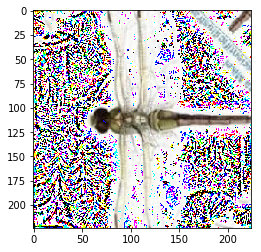

In [36]:
adv_tensor = norm(test_tensor)[0]
print(adv_tensor.shape)
plt.imshow((test_tensor+delta).detach().numpy().transpose(1,2,0))